In [1]:
import numpy as np
import tensorflow as tf
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
# import A flowers Datasets
import pathlib

data_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=data_URL, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 3s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


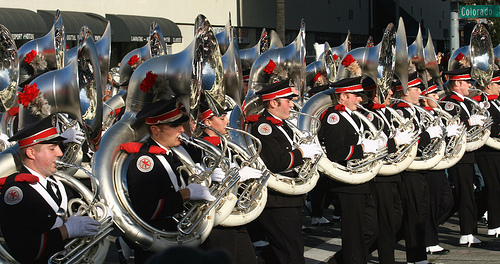

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

HHHHH crazy datasets

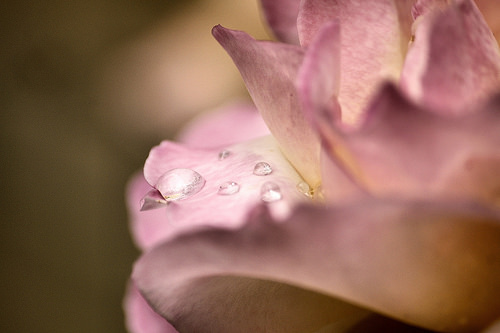

In [5]:
PIL.Image.open(str(roses[1]))

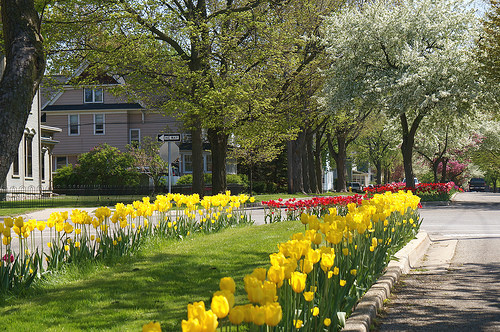

In [6]:
# some tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[2]))

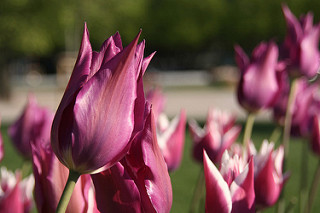

In [7]:
PIL.Image.open(str(tulips[1]))

## Load data using a Keras utility

In [8]:
# create a dataset
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
# find class names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

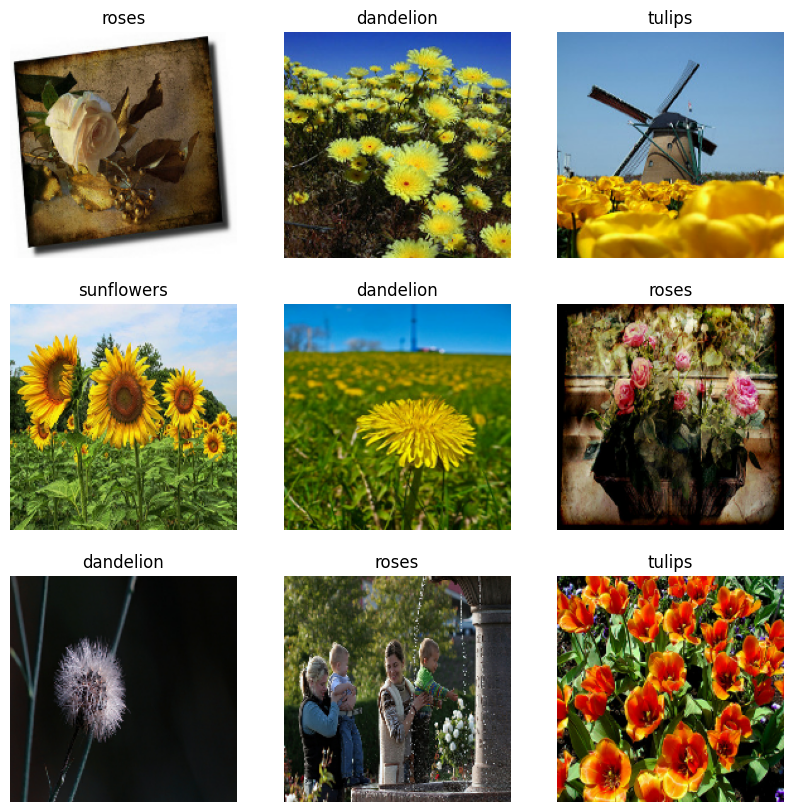

In [12]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Configure the dataset for performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## A basic Keras model

In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [20]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# models summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [22]:
# train the models
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
92/92 [==============================] - 18s 46ms/step - loss: 1.4014 - accuracy: 0.4029 - val_loss: 1.1022 - val_accuracy: 0.5409
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 1.0223 - accuracy: 0.5967 - val_loss: 1.0471 - val_accuracy: 0.5559
Epoch 3/10
92/92 [==============================] - 2s 22ms/step - loss: 0.8520 - accuracy: 0.6683 - val_loss: 0.9792 - val_accuracy: 0.6172
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6318 - accuracy: 0.7609 - val_loss: 1.0147 - val_accuracy: 0.6431
Epoch 5/10
92/92 [==============================] - 2s 22ms/step - loss: 0.4409 - accuracy: 0.8430 - val_loss: 1.0588 - val_accuracy: 0.6512
Epoch 6/10
92/92 [==============================] - 2s 24ms/step - loss: 0.2737 - accuracy: 0.9067 - val_loss: 1.2046 - val_accuracy: 0.6376
Epoch 7/10
92/92 [==============================] - 2s 22ms/step - loss: 0.1629 - accuracy: 0.9445 - val_loss: 1.3064 - val_accuracy: 0.6362
Epoch 8/10
9

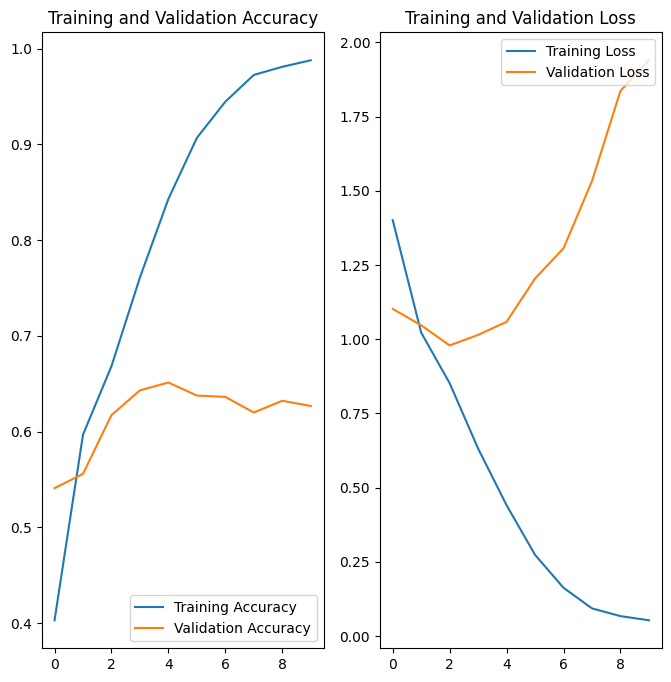

In [23]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
# Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

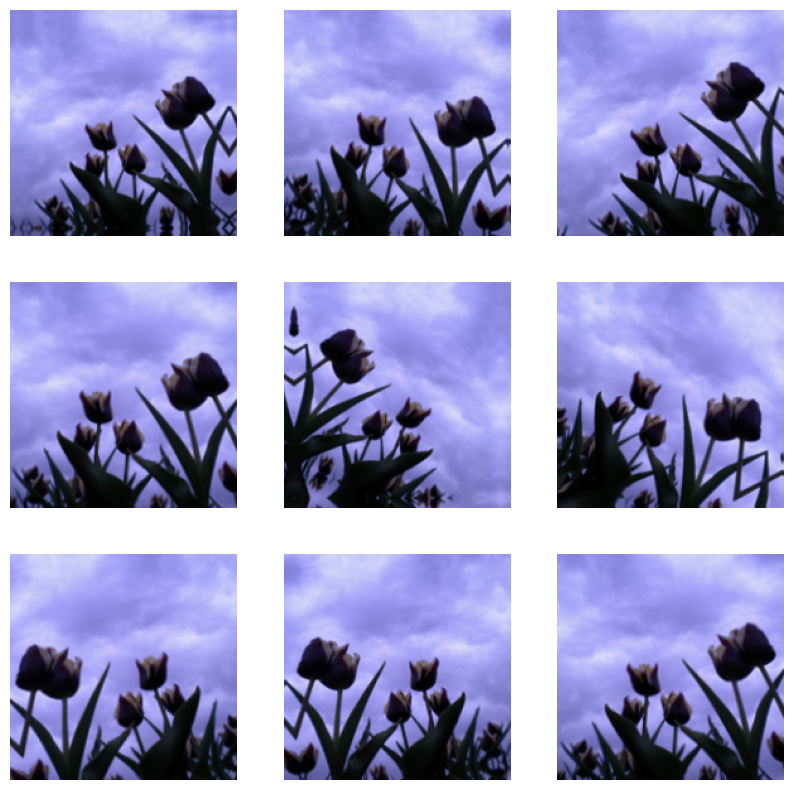

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
# Dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compile and train the model

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 34ms/step - loss: 1.2139 - accuracy: 0.4802 - val_loss: 1.1043 - val_accuracy: 0.5545
Epoch 2/15
92/92 [==============================] - 3s 30ms/step - loss: 1.0044 - accuracy: 0.6059 - val_loss: 1.0919 - val_accuracy: 0.5831
Epoch 3/15
92/92 [==============================] - 3s 32ms/step - loss: 0.9280 - accuracy: 0.6441 - val_loss: 0.9659 - val_accuracy: 0.6376
Epoch 4/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8411 - accuracy: 0.6700 - val_loss: 0.8772 - val_accuracy: 0.6649
Epoch 5/15
92/92 [==============================] - 3s 30ms/step - loss: 0.7950 - accuracy: 0.7027 - val_loss: 0.8782 - val_accuracy: 0.6635
Epoch 6/15
92/92 [==============================] - 3s 30ms/step - loss: 0.7523 - accuracy: 0.7088 - val_loss: 0.7768 - val_accuracy: 0.7057
Epoch 7/15
92/92 [==============================] - 3s 33ms/step - loss: 0.7146 - accuracy: 0.7289 - val_loss: 0.8038 - val_accuracy: 0.6839
Epoch 8/15
92

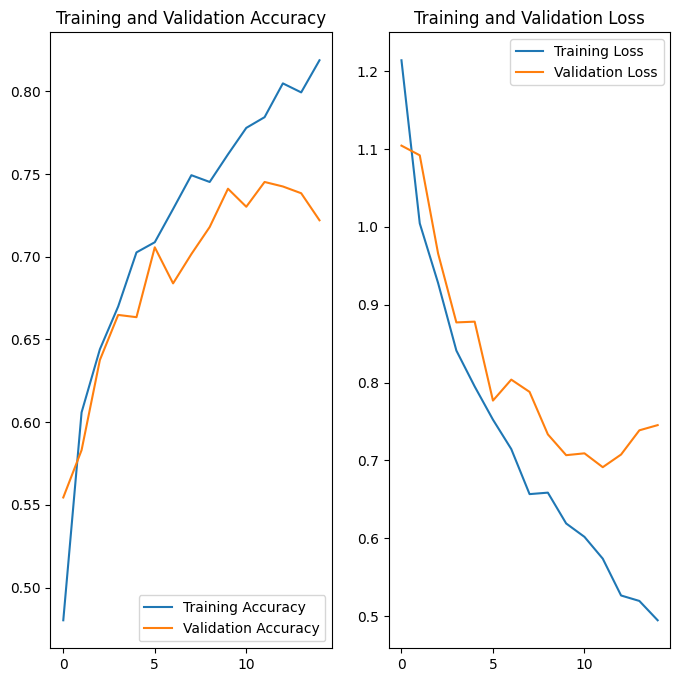

In [31]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()